With the importance placed on getting a college degree nowadays ([65 percent of workers have at least some postsecondary education](https://cew.georgetown.edu/cew-reports/americas-divided-recovery/)), students more than ever need to focus on getting into colleges that will best help them achieve their goals. Sites like [US News](https://www.usnews.com/best-colleges) have become the de-facto standard for students trying to search through hundreds of universities and deciding which is the best fit. Specifically, US News' ranking system is given enormous weight, influencing [how schools are perceived by the general public](https://www.forbes.com/sites/robertzafft/2021/12/07/us-news-business-school-rankings-crucial-but-meaningless/).



## Part 1: Web Scraping
After spending 8 hours or so writing a web scraper to get all the components from the website, it turns out that each page provides JSON objects that contain all the data in a much easier to extract format. Oh well. 

In [38]:
from bs4 import BeautifulSoup

html_doc = open("2022 Best National Universities US News Rankings.htm", encoding="utf8")
soup = BeautifulSoup(html_doc, 'html.parser')

In [39]:
anchors = soup.select('a[class*="card-name"]')
links = list(map(lambda x: x.get('href'), anchors))
print(links[:10])
print(len(links))

['https://www.usnews.com/best-colleges/princeton-university-2627', 'https://www.usnews.com/best-colleges/columbia-university-2707', 'https://www.usnews.com/best-colleges/harvard-university-2155', 'https://www.usnews.com/best-colleges/massachusetts-institute-of-technology-2178', 'https://www.usnews.com/best-colleges/yale-university-1426', 'https://www.usnews.com/best-colleges/stanford-university-1305', 'https://www.usnews.com/best-colleges/university-of-chicago-1774', 'https://www.usnews.com/best-colleges/university-of-pennsylvania-3378', 'https://www.usnews.com/best-colleges/california-institute-of-technology-1131', 'https://www.usnews.com/best-colleges/duke-university-2920']
392


In [40]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json

link = "https://www.usnews.com/best-colleges/princeton-university-2627"

def get_soup_obj(link, subpage):
    url = link + "/" + subpage
    agent = {"User-Agent":'Mozilla/5.0'}
    response = requests.get(url, headers = agent)
    return BeautifulSoup(response.text, 'html.parser')

soup = get_soup_obj(link, "student-life")

Then, we look at the structure of the HTML files and find the line in the script containing the JSON object, and extract it:

In [77]:
def get_json_from_soup(soup_obj):
    script_json_line = soup_obj.find_all("script")[-2].contents[0].split("\n")[4]
    json_obj_str = script_json_line[script_json_line.find("{"):-1].replace("undefined","null")
    json_obj = json.loads(json_obj_str)
        
    base_key = 'src/containers/pages/education/higher-education/colleges/profile'
    json_data = json_obj.get(f'{base_key}/overview.js',False) or \
                json_obj.get(f'{base_key}/generic.js',False) or \
                json_obj.get(f'{base_key}/rankings.js',None)
    
    return json_data['data']['context']['data']['page'] 

The 'fields' data indicates how the data is structured, the 'schoolData' field provides the values, and 'schoolDetails' provides basic info not in 'schoolData'.

We can use these methods to get all the data from every university and put it in a single JSON object, with the university name as the key.

In [ ]:
all_univ_json_data = {}
pages = ["", "overall-rankings", "applying", "academics", "student-life", "paying", "campus-info"]
for link in links:
    json_out = {'fields': {}, 'data': {}}
    for page in pages:
        json_data_fields = get_json_from_soup(get_soup_obj(link,page))
        #print(page + "::" + str(json_data_fields)[:20])
        json_out['data'].update(json_data_fields['schoolData'])
        json_out['fields'].update(json_data_fields['fields'])
    json_out['details'] = get_json_from_soup(get_soup_obj(link,""))['schoolDetails']
    name = json_out['details']['displayName']
    all_univ_json_data[name] = json_out
    print(name)

In [155]:
with open('all_univ.json', 'w') as outfile:
    json.dump(all_univ_json_data, outfile)

### Part 1.2: Data Compression

In [44]:
import json

# Read in the university data
with open('all_univ.json', 'r') as infile:
    all_univ_json_data = json.load(infile)

There are a lot of unnecessary fields in this data that we can remove, to make our analysis life a lot easier.

In [52]:
nested_fields = set()

def create_field_label_keys():
    # Assumes that all of the possible data attributes are contained within the first university on the list
    key = {}
    # Iterate through fields, putting the labels and fieldNames into a dictionary for future reference
    for field in all_univ_json_data['Princeton University']['fields'].values():
        if 'fieldName' in field:
            key[field['fieldName']] = field['label']
    return key    
    
def get_data_value(univ, field_name):
    return univ['data'][field_name]['rawValue'] if 'rawValue' in univ['data'][field_name] else None

def get_field_value(univ, field):
    if 'subFields' in field:
        subfields = {}
        for subfield in field['subFields']:
            subfield_fields = subfield['fields'] if "fields" in subfield else [subfield['field']] 
            for subfield_field in subfield_fields:
                nested_fields.add(subfield_field)
                subfields[subfield_field] = get_data_value(univ, subfield_field)
        return subfields
    else:
        if field['fieldName'] not in nested_fields:
            return get_data_value(univ, field['fieldName'])

# Returns a tuple; the first value is the actual data, the second is the additional part of the key mapping
def get_details_info(univ):
    univ_details = univ['details'].copy()
    univ_details.pop("mainRank")
    univ_details.pop("crossWalk")
    keys = {}
    ranks = {}
    for rank_name, rank_data in univ_details['ranks'].items():
        if rank_data['isPublic'] and not rank_data['locked']:
            keys[rank_name] = rank_data['displayName']
            ranks[rank_name] = rank_data['displayRank']
    univ_details['ranks'] = ranks
    return (univ_details, keys)

univ_keys = create_field_label_keys() # map between field keys and readable labels

all_univ_data = []
for name, univ in list(all_univ_json_data.items()):
    univ_data = {}
    # Add info from 'details'
    details_data, details_keys = get_details_info(univ)
    univ_keys.update(details_keys)
    univ_data.update(details_data)   
    
    for field in univ['fields'].values():
        if field['isPublic']: 
            field_value = get_field_value(univ, field)
            if field_value is not None:
                univ_data[field['fieldName']] = field_value

    all_univ_data.append(univ_data)
    #print(name)

In [53]:
with open('all_univ_compressed.json', 'w') as outfile:
    json.dump(all_univ_data, outfile)
with open('all_univ_compressed_key.json', 'w') as outfile:
    json.dump(univ_keys, outfile)

For some reason, there are certain values (like the average salary of recent graduates) which are visible on the website but aren't in the data set; I'll just live with that for now.

## Part 2: Analysis

US News gives all colleges a score on a scale from 0 to 100, where a higher number is better. They describe what exact factors contribute to this ranking and their relative percentages [on the website](https://www.usnews.com/best-colleges/university-of-maryland-2103/overall-rankings).

First, let's ask a rather obvious question: does the ranking done by US News correlate with other metrics of success, like starting salary? Unfortunately, because this scraper doesn't by itself get the data about average salary, I need to supplement this with another web scraper I wrote which directly reads from the webpage (**link**). 

In [146]:
#!pip install statsmodels
#!pip install ijson
#!pip install sklearn

In [4]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import json

In [5]:
with open('all_univ_compressed.json', 'r') as infile:
    all_univ_data = json.load(infile)
with open('all_univ_compressed_key.json', 'r') as infile:
    data_key = json.load(infile)

In [60]:
univ_df = pd.DataFrame(all_univ_data)

salaries = pd.read_csv("all_univ_rows.csv")["Median starting salary of alumni "].apply( 
          lambda x: x if pd.isna(x) else int(x[1:].replace(",","")))
univ_df['payscaleOverallStarting'] = salaries

univ_df["vDisplayScore"] = univ_df["vDisplayScore"].apply(lambda x: x if isinstance(x,int) else np.nan)
univ_df["vStudentFacultyRatio"] = univ_df["vStudentFacultyRatio"].apply(\
                        lambda x: int(x[:-2]) if pd.notna(x) else np.nan)

# Normalize set of columns
def json_normalize_column(df, col_name):
    return pd.concat([df,pd.json_normalize(df[col_name])], axis=1)

for col in ["gStudentGenderDistribution", "gFraternityMembers", "gSororityMembers"]:
    univ_df = json_normalize_column(univ_df, col)

univ_df.head()

,primaryKey,xwalkId,urlName,displayName,shortName,city,state,zip,website,streetAddress1,...,vInStateTuition,vOutStateTuition,internationalTestReqMichiganTest,payscaleOverallStarting,vPctUnderMen,vPctUnderWomen,stuCatFraternityUg,stuCatNoFraternityUg,stuCatSororityUg,stuCatNoSororityUg
0,2627,186131,princeton-university,Princeton University,Princeton University,Princeton,NJ,08544,http://www.princeton.edu,N/A,...,NaN,NaN,NaN,71300.0,50.0,50.0,0,100,0,100
1,2707,190150,columbia-university,Columbia University,Columbia University,New York,NY,10027,http://www.columbia.edu,2960 Broadway,...,NaN,NaN,NaN,67800.0,49.0,51.0,14,86,12,88
2,2155,166027,harvard-university,Harvard University,Harvard University,Cambridge,MA,02138,http://www.harvard.edu/,N/A,...,NaN,NaN,NaN,69000.0,49.0,51.0,0,0,0,0
3,2178,166683,massachusetts-institute-of-technology,Massachusetts Institute of Technology,Massachusetts Institute of Technology,Cambridge,MA,02139,http://web.mit.edu/,77 Massachusetts Avenue,...,NaN,NaN,NaN,82700.0,52.0,48.0,39,61,26,74
4,1426,130794,yale-university,Yale University,Yale University,New Haven,CT,06520,http://www.yale.edu/,N/A,...,NaN,NaN,NaN,65900.0,50.0,50.0,0,0,0,0


[Text(0.5, 1.0, 'Median Alumni Starting Salary vs University Scores'),
 Text(0.5, 0, 'Median Salary of Recent Alumni (USD)'),
 Text(0, 0.5, 'US News Score (0-100)')]

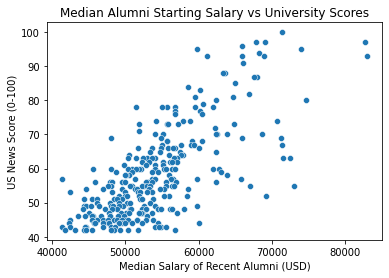

In [26]:
ax = sns.scatterplot(data=univ_df, x="payscaleOverallStarting", y="vDisplayScore")
ax.set(title="Median Alumni Starting Salary vs University Scores",xlabel="Median Salary of Recent Alumni (USD)",ylabel="US News Score (0-100)")

We can see a decent positive linear correlation, as we'd expect; however, we had to remove the bottom score values from the graph because US News doesn't give a specific number for any university in the bottom 25 percent. This means any university with a score under 42 cannot be predicted from the given data. It's unknown how this will affect the results (if at all), but it's worth keeping in mind.

We can quantify the relationship with a predictive model:

In [11]:
reg = smf.ols("vDisplayScore ~ payscaleOverallStarting", data=univ_df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vDisplayScore   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     317.8
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           8.50e-49
Time:                        21:24:07   Log-Likelihood:                -1089.2
No. Observations:                 298   AIC:                             2182.
Df Residuals:                     296   BIC:                             2190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -15.4176      4.175     -3.693      0.000     -23.633      -7.202
payscaleOverallStarting     0.0014   7.64e-05     17.827      0.000       0.001       0.002
==============================================================================
Omnibus:                        2.100   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.805
Skew:                           0.142   Prob(JB):                        0.406
Kurtosis:                       3.255   Cond. No.                     4.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An r-squared of 0.518 means that there is some correlation, but it's not particularly strong.

#### 2.1.2: Adjusting For Major

However, the school one attends is obviously not the only factor that controls your salary. One huge factor is your field -- chemical engineers, on average, earn significantly more than English teachers. We can try and account for this by looking at the top 10 most popular majors for each school, then referencing an external data set like [this table from the Wall Street Journal](https://online.wsj.com/public/resources/documents/info-Degrees_that_Pay_you_Back-sort.html) to find the *expected* average salary based on major. 

In [32]:
from collections import Counter

majors = univ_df["topMajors"][univ_df["topMajors"].notna()]
majors = [item[0] for major_univ in majors for item in major_univ]
Counter(majors)

Counter({'Social Sciences': 150,
         'Engineering': 120,
         'Computer and Information Sciences and Support Services': 98,
         'Biological and Biomedical Sciences': 165,
         'Public Administration and Social Service Professions': 17,
         'Physical Sciences': 31,
         'History': 10,
         'Foreign Languages, Literatures, and Linguistics': 11,
         'English Language and Literature/Letters': 38,
         'Philosophy and Religious Studies': 5,
         'Mathematics and Statistics': 32,
         'Visual and Performing Arts': 93,
         'Psychology': 149,
         'Social Sciences, General': 5,
         'Biology/Biological Sciences, General': 64,
         'Mathematics, General': 9,
         'Computer and Information Sciences, General': 15,
         'History, General': 4,
         'Physical Sciences, General': 1,
         'Engineering, General': 6,
         'Psychology, General': 75,
         'English Language and Literature, General': 7,
         'Visual

The problem here is mapping these majors to any specific data set is really hard. [TODO]

### 2.2 Predicting Rankings

Unfortunately, unless you pay for premium access, you are only able to see a small portion of the factors that go into the ranking:

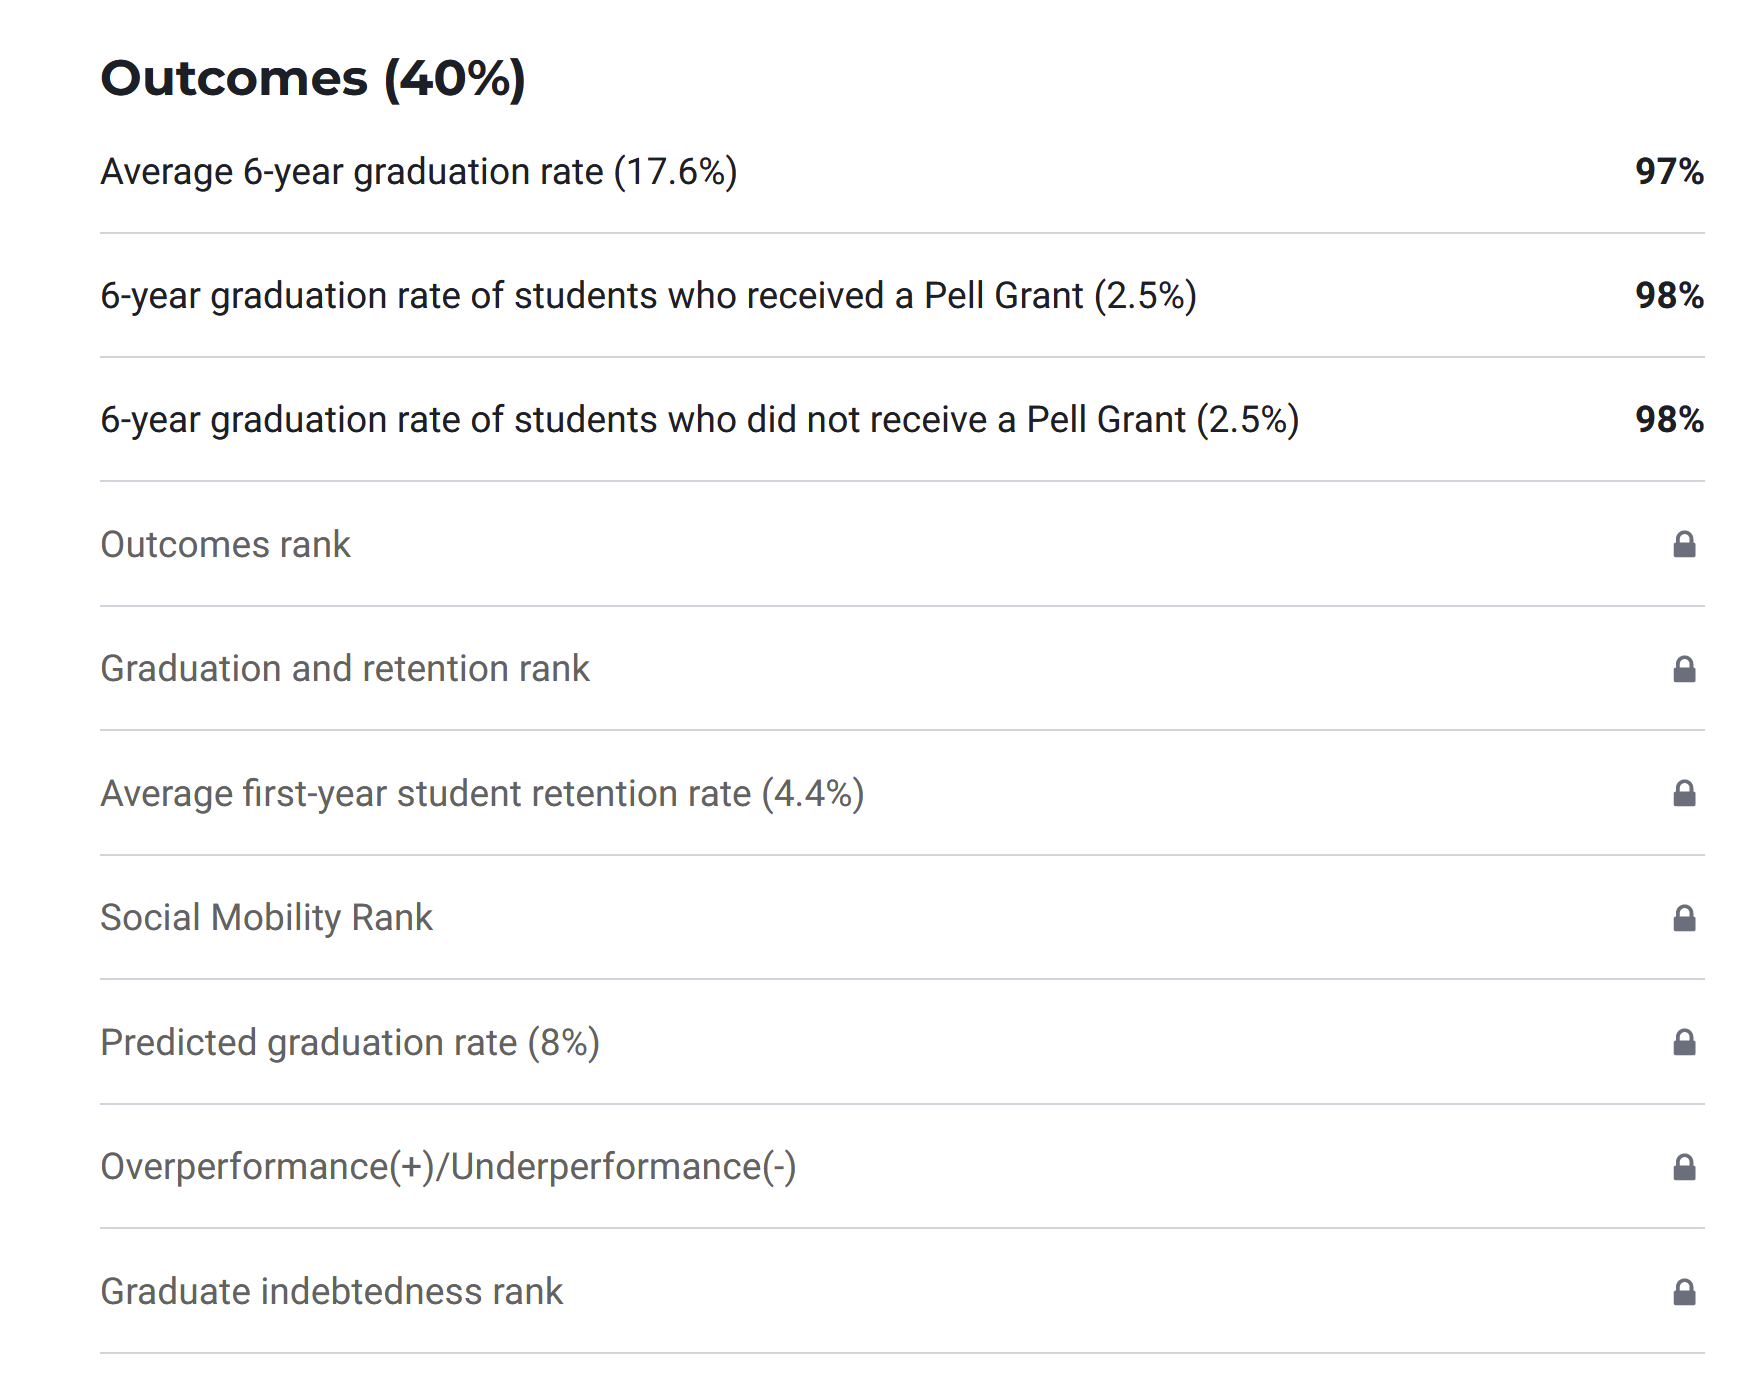

Specifically, a non-paying reader can only see data about the average graduation rate, student class sizes, and the student-faculty ratio. But that leads one to ask: how much do those factors matter? Is the correlation between the different factors strong enough that we can predict the rankings using only the factors that we can access for free?

The first place to start would be with a linear regression model. However, in order for this model to make sense, we have to make the assumption that the variables vary linearly with respect to desired output variable (the score). Let's check that graphically:

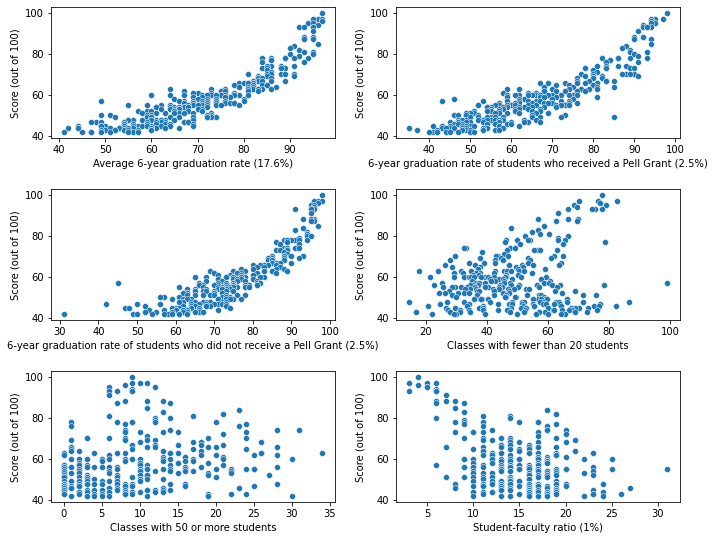

In [25]:
from math import ceil 

ranking_factors = ["rCAvgPctGrad6Yr", "pellGradRate",  "nonPellGradrate", 
                   "rCPctClasses119", "rCPctClassesGt50", "vStudentFacultyRatio"]

def plot_factors_against_score(ranking_factors, ncols):
    fig, axes = plt.subplots(nrows=ceil(len(ranking_factors)/ncols),ncols=ncols, figsize=(10,8))
    fig.tight_layout(pad=3.0)
    for col, ax in zip(ranking_factors, fig.axes):
        sns.scatterplot(ax=ax, x=col, y="vDisplayScore", data=univ_df)
        ax.set(xlabel=data_key[col], ylabel=data_key["vDisplayScore"])
        
plot_factors_against_score(ranking_factors, 2)

This data is very interesting -- some of these appear to have little to no correlation with the data (specifically those relating to class sizes) and some of these have a quite strong, *non-linear* relationship (specifically those regarding graduation rates). Therefore, a linear model is definitely not a good idea here.

Obviously, the graphs with overall average 6-year graduation rate are very similar to those regarding graduation rate of Pell Grant and non-Pell Grant recipients. 

The apparent strength of the graduation rate versus score relationship on the graph makes me wonder about how well a polynomial predictive model could do when input only the 6-year graduation rate (i.e. a single-variable model).

In [13]:
#https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html
from sklearn.preprocessing import PolynomialFeatures
univ_df = univ_df[pd.notna(univ_df["vDisplayScore"])]
x = univ_df["rCAvgPctGrad6Yr"].ravel().reshape(-1, 1)
y = univ_df["vDisplayScore"]

polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)

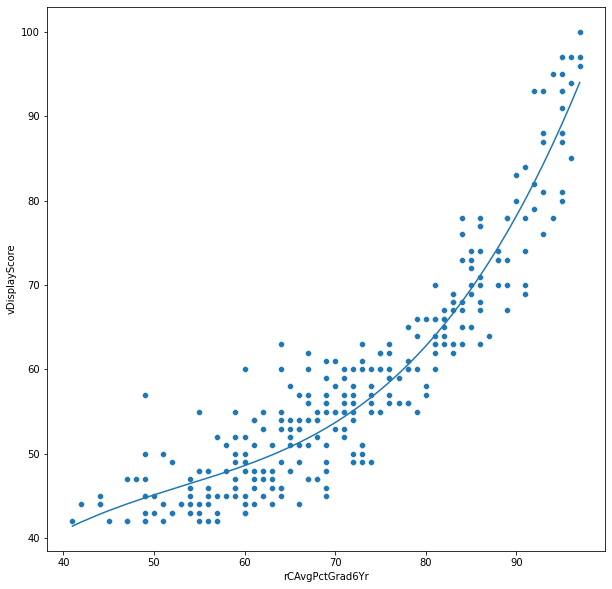

In [14]:
import statsmodels.api as sm
model = sm.OLS(y,xp).fit()
ypred = model.predict(xp) 

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="rCAvgPctGrad6Yr",y="vDisplayScore",data=univ_df)
x, ypred = zip(*sorted(zip(x, ypred)))
ax.plot(x,ypred)

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vDisplayScore   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     879.5
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          1.90e-146
Time:                        21:24:14   Log-Likelihood:                -855.14
No. Observations:                 298   AIC:                             1718.
Df Residuals:                     294   BIC:                             1733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.6150     28.749     -1.065      0.288     -87.196      25.966
x1             3.6685      1.273      2.883      0.004       1.164       6.173
x2            -0.0627      0.018     -3.415      0.001      -0.099      -0.027
x3             0.0004   8.66e-05      4.546      0.000       0.000       0.001
==============================================================================
Omnibus:                        1.801   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.739
Skew:                           0.187   Prob(JB):                        0.419
Kurtosis:                       2.977   Cond. No.                     5.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With an R-squared of 0.9, we can see this is a really good predictor of ranking, even though it apparently only account for 17.6 percent of the ranking. The p-values of the various factors are significantly below the standard threshold of 0.05, so they are clearly statistically significant.

### Part 2.3: Transforming The Data
However, it's unusual that the relationship isn't linear. Since these metrics are artificially created by US News, one would expect there to be a more obvious mathematical relationship between the ranking factors and the rank. According to the [US News website](https://www.usnews.com/education/best-colleges/articles/how-us-news-calculated-the-rankings), they "normalize" the values before they are put into the calculation. This may mean that instead of looking at the raw value, we should look at the *z-score* of each ranking, which is a measure that describes how far away from the mean the value is. However, for z-score to be a useful measure, we would also need to make the assumption that scores are normally distributed. Let's check that first, by observation: 

<AxesSubplot:xlabel='rCAvgPctGrad6Yr', ylabel='Count'>

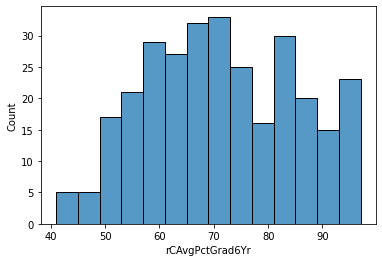

In [16]:
sns.histplot(x="rCAvgPctGrad6Yr",data=univ_df,bins=14)

Well, it looks pretty normal, with the exception of the higher-than-expected bunching at the higher graduation rates. 

To quantify this more accurately, we can use a QQ plot, which compares the *quantiles* (percentiles) of the sample with what would be expected if the sample was normally distributed. If the sample is perfectly normal, then we would expect to see a perfect line. 

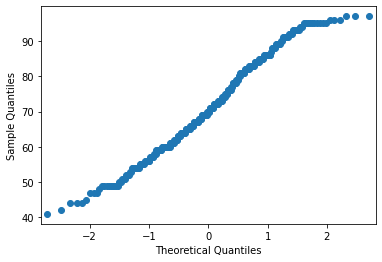

In [17]:
ax = sm.qqplot(univ_df["rCAvgPctGrad6Yr"])

Again, we see a very close to normal relationship with the exception of the values trailing off near the top. Either way, I'm comfortable say the distribution is normal *enough* that we can use z-scores to describe the data points.  

[Text(0.5, 0, 'Average 6-year graduation rate (17.6%) (z score)'),
 Text(0, 0.5, 'Score (out of 100)')]

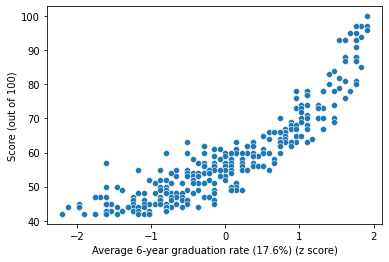

In [18]:
from scipy import stats
univ_df["rCAvgPctGrad6YrZScore"] = stats.zscore(univ_df["rCAvgPctGrad6Yr"])
ax = sns.scatterplot(x="rCAvgPctGrad6YrZScore",y="vDisplayScore", data=univ_df)
ax.set(xlabel=data_key["rCAvgPctGrad6Yr"] + " (z score)", ylabel=data_key["vDisplayScore"])

However, it seems that normalizing the values didn't actually make the relationship any more linear.

While US News claims to be transparent about how they do their rankings, the above data shows that it's not as obvious as it seems. There's more going on for this ranking than just taking the data and adding it together. They either do additional statistical work before ranking, or there's some hidden relationships in the data that make the rankings work unusually, which isn't accounted for in US News' explanation. Either way, people should know this when they are putting faith in ranking authorities like US News.

## Part 2.3: Other Correlations
Are there any other factors that correlate well with rank, despite not being used in the ranking calculation?

In [57]:
#pd.json_normalize(all_univ_data)
#univ_df["vPctUnderMen"]
#pd.json_normalize(univ_df.loc[:,["gStudentGenderDistribution","vDisplayScore"]])
#univ_df["gStudentGenderDistribution"]

#sns.scatterplot(x="vPctUnderMen", y="vDisplayScore", data=univ_df)

[TODO]

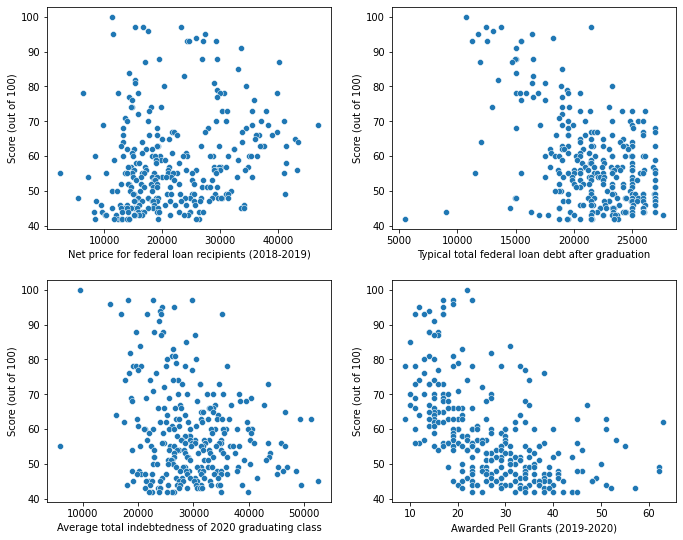

In [38]:
other_factors = ["csAvgCost", "csTypicalDebt", "avgGradDebt", "pctPell"]
plot_factors_against_score(other_factors, 2)

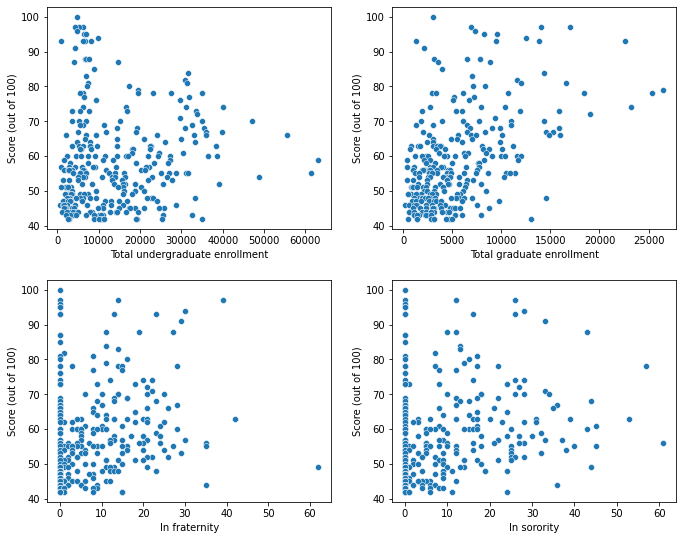

In [58]:
other_factors = ["totalUndergrads", "totalGradsAndPros", "stuCatFraternityUg", "stuCatSororityUg"]
plot_factors_against_score(other_factors, 2)

TODO: Remove the points where no fraternities or sororities